In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
!pip install transformers
!pip install --upgrade transformers
!pip install tensorflow-io
!pip install tensorflow-text

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 MB 28.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 88.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 72.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 106.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 79.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 42.7 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.2.0
    Uninstalling ml-dtypes-0.2.0:
      Successfully uninstalled ml-dtypes-0.2.0
  Attempting uninstall: h5py
    Found existing installation: h5py 3.9.0
    Uninstalling h5py-3.9.0:
      Successfully uninstalled h5py-3.9.0
  Attempting uninstall: tensorboard
    Found exis

In [3]:
!pip uninstall -y tensorflow
!pip install tensorflow==2.15.0

Found existing installation: tensorflow 2.16.1
Uninstalling tensorflow-2.16.1:
  Successfully uninstalled tensorflow-2.16.1
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 69.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 89.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 86.7 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.3.2
    Uninstalling ml-dtypes-0.3.2:
      Successfully uninstalled ml-dtypes-0.3.2
  Attempting uninstall: keras
    Found existing installation: keras 3.3.3
    Uninstalling keras-3.3.3:
      Successfully uninstalled keras-3.3.3
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.16.2
    Uninstalling tensorboard-2.16.2:
      Successfully uninstalled tensorboard-2.16.2
ERROR: pip's dependency resolver does not currently take into account 

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import os
import time
import subprocess
import torch
import tensorflow as tf
import keras
from tensorflow.python.keras import activations, optimizers, losses
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score, auc, roc_curve, roc_auc_score
import transformers
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification

In [5]:
print(transformers.__version__)

4.41.2


# Functions

In [6]:
def load_data(file_path):
    data_ = pd.read_csv(file_path)
    print(data_.head())

    return data_

In [7]:
def plot_scores_across_folds(scores_list, eval_metrics, output_file=None):
    num = len(scores_list)
    plt.plot(scores_list, marker="o", label=eval_metrics)
    plt.xlabel("Fold")
    plt.ylabel(f"{eval_metrics}")
    plt.title(f"{eval_metrics} across Folds")
    plt.legend()
    plt.xticks(range(0, num), [str(i+1) for i in range(num)])
    plt.show()

    if output_file:
        plt.savefig(output_file)

In [8]:
def pred_performance_measure(model, val_dataset, labels_val):
    # perform prediction on the validation dataset
    predictions = model.predict(val_dataset)
    predicted_probs = predictions[0][:, 0] # use the first output and raw logits directly
    predicted_labels = (predicted_probs >= 0.5).astype(int) # convert probability into binary labels

    # create confusion matrix
    confusion_matrix_data = tf.math.confusion_matrix(labels_val, predicted_labels)
    plt.figure(figsize=(5,3))
    sns.heatmap(confusion_matrix_data, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.xlabel("Predicted Label")
    plt.ylabel("Actual Label")
    plt.title("Confusion Matrix")
    plt.show()

    # calculate row sums (actual label counts) and column sums (predicted label counts)
    row_cnt = confusion_matrix_data.numpy().sum(axis=1)
    col_cnt = confusion_matrix_data.numpy().sum(axis=0)
    confusion_matrix_perc = (confusion_matrix_data/row_cnt[:, np.newaxis])*100
    plt.figure(figsize=(5,3))
    sns.heatmap(confusion_matrix_perc, annot=True, fmt=".2f", cmap="Blues", cbar=False)
    plt.xlabel("Predicted Label")
    plt.ylabel("Actual Label")
    plt.title("Confusion Matrix (%)")
    plt.show()

    accuracy = accuracy_score(labels_val, predicted_labels)
    precision = precision_score(labels_val, predicted_labels)
    recall = recall_score(labels_val, predicted_labels)
    f1 = f1_score(labels_val, predicted_labels)
    roc_auc = roc_auc_score(labels_val, predicted_probs)

    # create and display ROC AUC plot
    fpr, tpr, _ = roc_curve(labels_val, predicted_probs)
    plt.figure(figsize=(5,3))
    plt.plot(fpr, tpr, label="ROC Curve (area = %0.2f)" % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc='lower right')
    plt.show()

    return accuracy, precision, recall, f1, roc_auc

In [9]:
def calc_avg_cv(accuracy_scores_list, precision_scores_list, recall_scores_list, f1_scores_list, roc_auc_values, n_folds):
    """
    calculate the average value after n-fold of cross validation
    """
    final_accuracy = sum(accuracy_scores_list) / n_folds
    final_precision = sum(precision_scores_list) / n_folds
    final_recall = sum(recall_scores_list) / n_folds
    final_f1 = sum(f1_scores_list) / n_folds
    final_roc_auc = sum(roc_auc_values) / n_folds

    return final_accuracy, final_precision, final_recall, final_f1, final_roc_auc

In [10]:
def get_gpu_memory():
    try:
        result = subprocess.check_output(
            [
                'nvidia-smi', '--query-gpu=memory.used,memory.total',
                '--format=csv,nounits,noheader'
            ]).decode('utf-8')

        gpu_memory = result.strip().split('\n')
        memory_info = []

        for info in gpu_memory:
            used, total = info.split(',')
            memory_info.append((int(used), int(total)))

        return memory_info

    except subprocess.CalledProcessError as e:
        print(f"Error in fetching GPU memory info: {e}")
        return None

In [11]:
def print_gpu_memory_usage():
    memory_info = get_gpu_memory()
    if memory_info:
        for idx, (used, total) in enumerate(memory_info):
            print(f"GPU {idx+1}: Used Memory: {used} MB, Total Memory: {total} MB")

In [12]:
def save_result_to_csv(accuracy, precision, recall, f1_score, roc_auc, csv_filepath):
    if os.path.exists(csv_filepath):
        existing_df = pd.read_csv(csv_filepath)
    else:
        existing_df = pd.DataFrame()

    new_row = pd.DataFrame({
        "Accuracy": [accuracy],
        "Precision": [precision],
        "Recall": [recall],
        "F1_Score": [f1_score],
        "ROC AUC": [roc_auc]
    })

    existing_df = pd.concat([existing_df, new_row], ignore_index=True)
    existing_df.to_csv(csv_filepath, index=False)

    return existing_df

# Import Data

In [13]:
data = load_data("/content/drive/MyDrive/MDS_FYP/Data/cleaned_data.csv")

                                                text  label
0  ['ex', 'wife', 'threaten', 'suiciderec', 'left...      1
1  ['weird', 'dont', 'get', 'affect', 'compliment...      0
2  ['final', 'almost', 'never', 'hear', 'bad', 'y...      0
3  ['need', 'helpjust', 'help', 'im', 'cri', 'hard']      1
4  ['im', 'losthello', 'name', 'adam', 'ive', 'st...      1


# DistilBERT

In [14]:
BATCH_SIZE = 128
N_FOLDS = 5
N_EPOCHS = 4
LEARNING_RATE = 2e-5
input_ids = []
attention_masks = []

labels = np.array(data["label"])

MODEL_NAME = "distilbert-base-uncased"
tokenizer = DistilBertTokenizer.from_pretrained(MODEL_NAME)
encodings = {
    "input_ids": [],
    "attention_mask": []
}

for text_row in data["text"]:
    text_str = " ".join(text_row)
    tokens = tokenizer(text_row, truncation=True, padding="max_length", max_length=64, return_tensors="tf")
    input_ids.append(tokens["input_ids"])
    attention_masks.append(tokens["attention_mask"])

input_ids = np.array(input_ids)
attention_masks = np.array(attention_masks)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [15]:
print("Input IDs shape:", input_ids.shape)
print("Attention Masks shape:", attention_masks.shape)
print("Labels shape:", labels.shape)

Input IDs shape: (232074, 1, 64)
Attention Masks shape: (232074, 1, 64)
Labels shape: (232074,)


In [16]:
input_ids = np.squeeze(input_ids, axis=1)
attention_masks = np.squeeze(attention_masks, axis=1)
print("Input IDs shape:", input_ids.shape)
print("Attention Masks shape:", attention_masks.shape)
print("Labels shape:", labels.shape)

Input IDs shape: (232074, 64)
Attention Masks shape: (232074, 64)
Labels shape: (232074,)


In [17]:
input_data = np.array(list(zip(input_ids, attention_masks, labels)), dtype=object)

In [18]:
training_accuracies = []
training_losses = []
val_accuracies = []
val_losses = []
accuracy_scores_list = []
precision_scores_list = []
recall_scores_list = []
f1_scores_list = []
roc_auc_values = []

X_train, X_test, y_train, y_test = train_test_split(input_data[:, :-1], input_data[:, -1], test_size=0.3, random_state=42)

# Model Training

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

Fold 1/5
Epoch 1/4


Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
1451/1451 [==============================] - 682s 436ms/step - loss: 0.1497 - accuracy: 0.9389 - val_loss: 0.1077 - val_accuracy: 0.9571
Epoch 2/4
1451/1451 [==============================] - 630s 434ms/step - loss: 0.0930 - accuracy: 0.9637 - val_loss: 0.0970 - val_accuracy: 0.9631
Epoch 3/4
1451/1451 [==============================] - 630s 434ms/step - loss: 0.0717 - accuracy: 0.9724 - val_loss: 0.0994 - val_accuracy: 0.9606
Epoch 4/4
1451/1451 [==============================] - 630s 434ms/step - loss: 0.0548 - accuracy: 0.9788 - val_loss: 0.1105 - val_accuracy: 0.9632


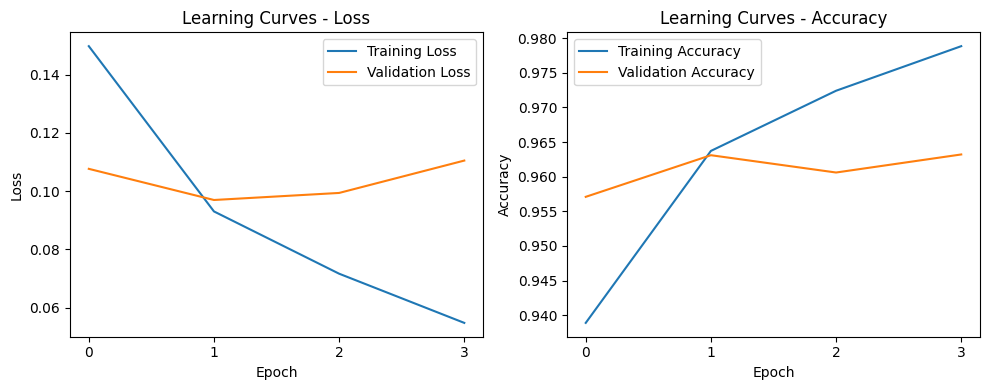

363/363 [==============================] - 52s 133ms/step


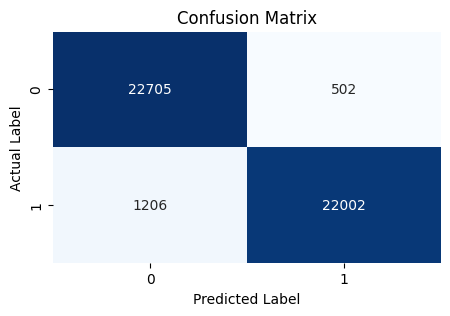

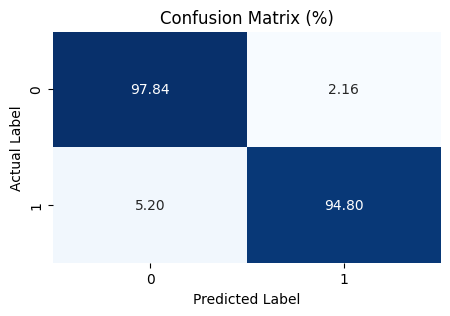

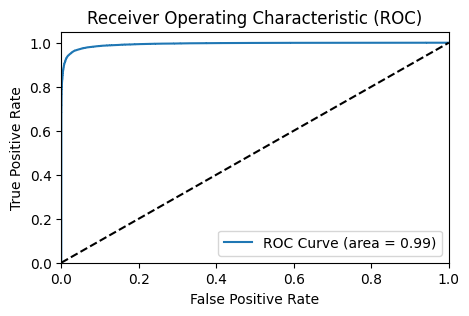

Fold 2/5
Epoch 1/4
1451/1451 [==============================] - 630s 434ms/step - loss: 0.0592 - accuracy: 0.9782 - val_loss: 0.0368 - val_accuracy: 0.9855
Epoch 2/4
1451/1451 [==============================] - 630s 434ms/step - loss: 0.0429 - accuracy: 0.9839 - val_loss: 0.0365 - val_accuracy: 0.9854
Epoch 3/4
1451/1451 [==============================] - 630s 434ms/step - loss: 0.0313 - accuracy: 0.9883 - val_loss: 0.0424 - val_accuracy: 0.9844
Epoch 4/4
1451/1451 [==============================] - 630s 434ms/step - loss: 0.0236 - accuracy: 0.9911 - val_loss: 0.0512 - val_accuracy: 0.9816


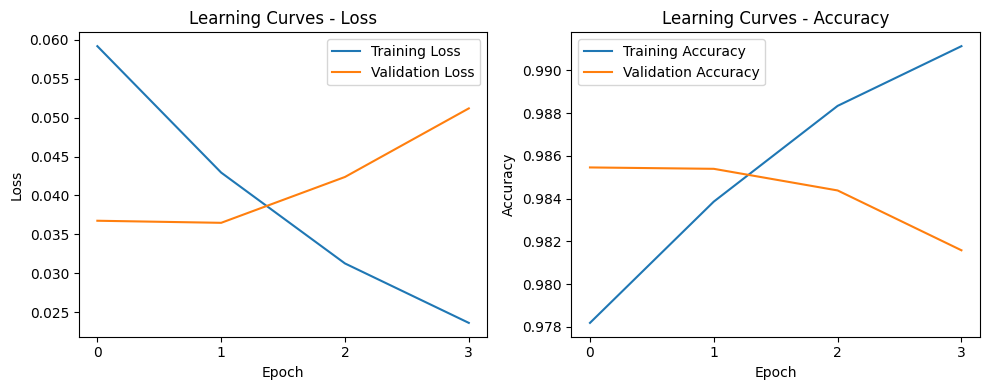

363/363 [==============================] - 48s 133ms/step


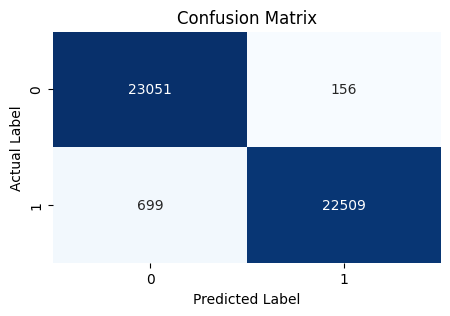

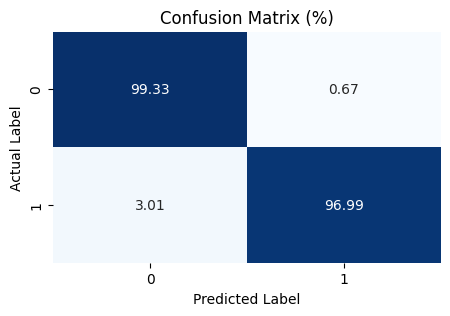

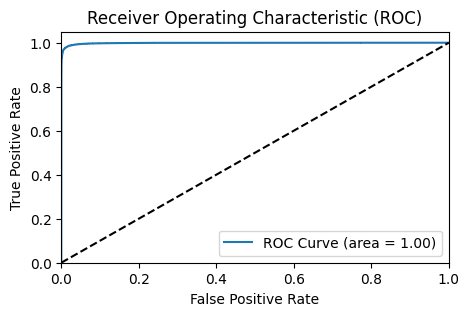

Fold 3/5
Epoch 1/4
1451/1451 [==============================] - 630s 434ms/step - loss: 0.0287 - accuracy: 0.9898 - val_loss: 0.0098 - val_accuracy: 0.9958
Epoch 2/4
1451/1451 [==============================] - 629s 433ms/step - loss: 0.0186 - accuracy: 0.9934 - val_loss: 0.0096 - val_accuracy: 0.9960
Epoch 3/4
1451/1451 [==============================] - 630s 434ms/step - loss: 0.0148 - accuracy: 0.9947 - val_loss: 0.0122 - val_accuracy: 0.9959
Epoch 4/4
1451/1451 [==============================] - 629s 433ms/step - loss: 0.0115 - accuracy: 0.9958 - val_loss: 0.0150 - val_accuracy: 0.9943


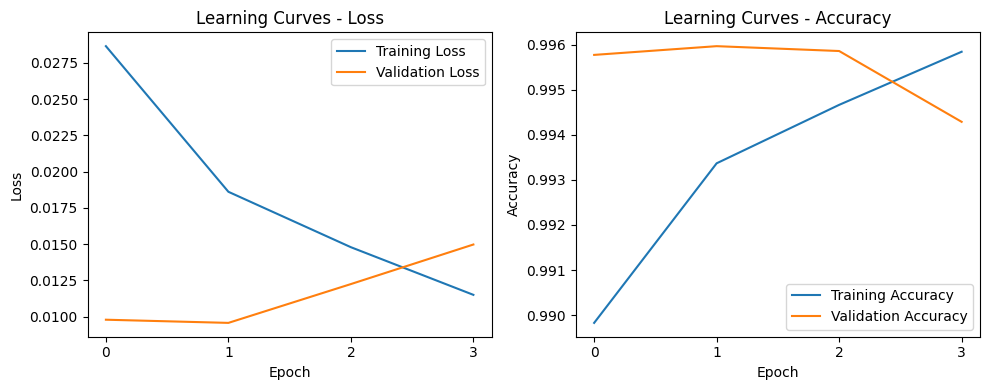

363/363 [==============================] - 48s 133ms/step


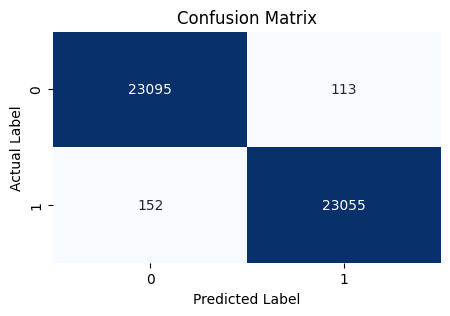

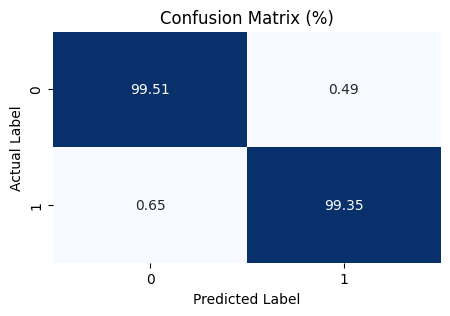

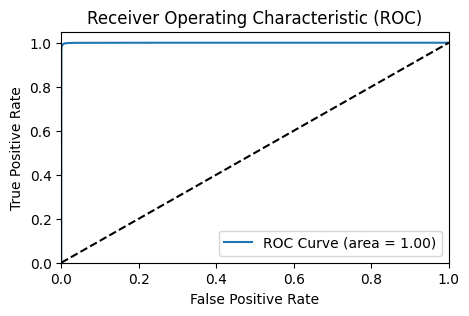

Fold 4/5
Epoch 1/4
1451/1451 [==============================] - 630s 434ms/step - loss: 0.0142 - accuracy: 0.9949 - val_loss: 0.0039 - val_accuracy: 0.9989
Epoch 2/4
1451/1451 [==============================] - 630s 434ms/step - loss: 0.0095 - accuracy: 0.9966 - val_loss: 0.0037 - val_accuracy: 0.9986
Epoch 3/4
1451/1451 [==============================] - 630s 434ms/step - loss: 0.0084 - accuracy: 0.9970 - val_loss: 0.0085 - val_accuracy: 0.9964
Epoch 4/4
1451/1451 [==============================] - 630s 434ms/step - loss: 0.0075 - accuracy: 0.9974 - val_loss: 0.0047 - val_accuracy: 0.9982


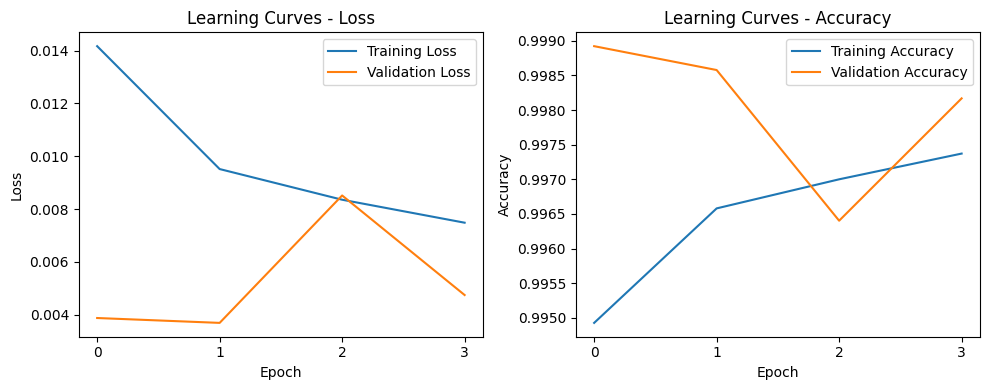

363/363 [==============================] - 48s 133ms/step


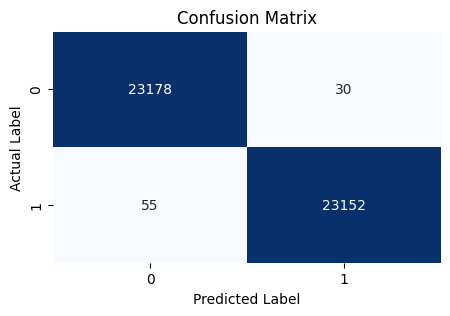

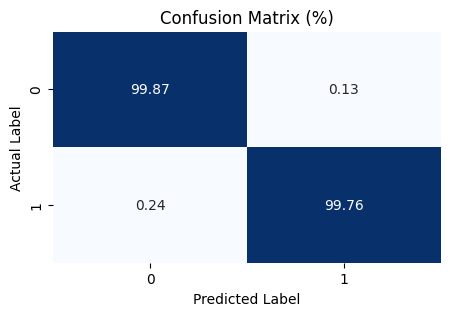

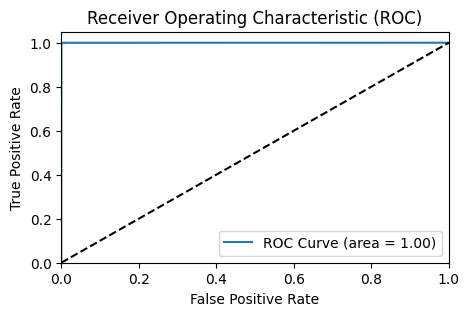

Fold 5/5
Epoch 1/4
1451/1451 [==============================] - 629s 433ms/step - loss: 0.0083 - accuracy: 0.9970 - val_loss: 0.0052 - val_accuracy: 0.9979
Epoch 2/4
1451/1451 [==============================] - 629s 433ms/step - loss: 0.0068 - accuracy: 0.9975 - val_loss: 0.0020 - val_accuracy: 0.9995
Epoch 3/4
1451/1451 [==============================] - 629s 433ms/step - loss: 0.0063 - accuracy: 0.9978 - val_loss: 0.0027 - val_accuracy: 0.9992
Epoch 4/4
1451/1451 [==============================] - 629s 433ms/step - loss: 0.0052 - accuracy: 0.9981 - val_loss: 0.0044 - val_accuracy: 0.9986


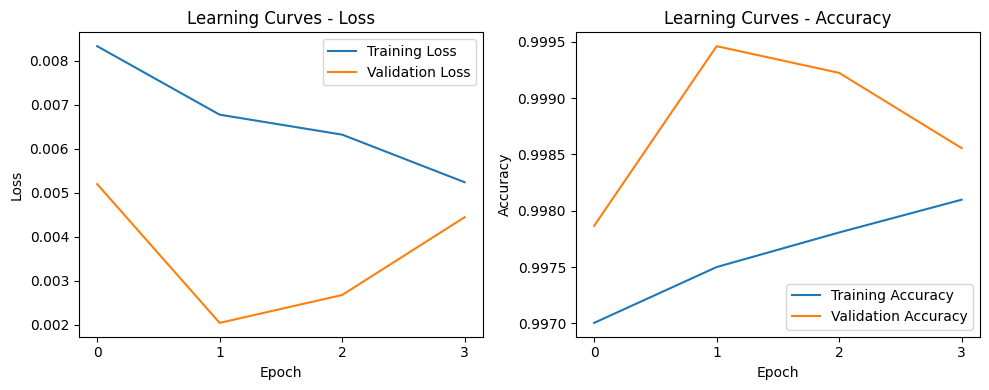

363/363 [==============================] - 48s 133ms/step


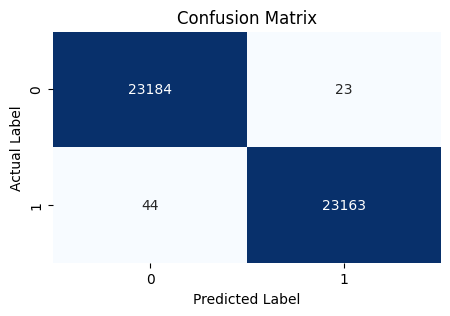

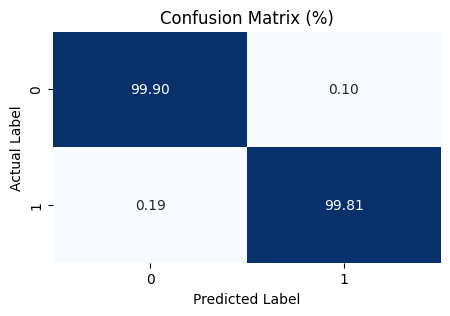

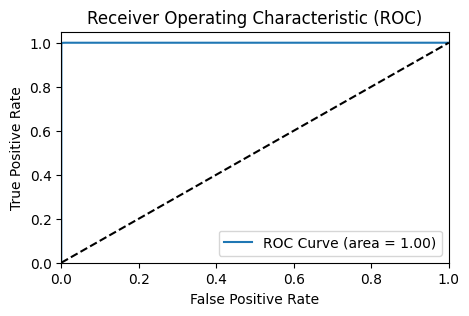

Total Training Time:  12905.06 seconds
GPU 1: Used Memory: 8479 MB, Total Memory: 23034 MB


In [19]:
model = TFDistilBertForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=1) # binary classifcation
model.layers[-1].activation = tf.keras.activations.sigmoid # add sigmoid activation to the output layer
kfold = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=42)
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True) # model outputs logits instead of probabilities
model.compile(optimizer=optimizer, loss=loss_fn, metrics=["accuracy"])

start_time = time.time()

# split data based on stratification of labels
for fold, (train_index, test_index) in enumerate(kfold.split(input_data, labels)):
    print(f"Fold {fold + 1}/{N_FOLDS}")

    # Split the data into train and validation sets for this fold
    input_train_fold, input_test_fold = input_data[train_index], input_data[test_index]
    input_ids_train_fold, attention_masks_train_fold, labels_train_fold = zip(*input_train_fold)
    input_ids_test_fold, attention_masks_test_fold, labels_test_fold = zip(*input_test_fold)

    # Convert the input data and labels to numpy arrays
    input_ids_train_fold = np.array(input_ids_train_fold)
    attention_masks_train_fold = np.array(attention_masks_train_fold)
    labels_train_fold = np.array(labels_train_fold)

    input_ids_test_fold = np.array(input_ids_test_fold)
    attention_masks_test_fold = np.array(attention_masks_test_fold)
    labels_test_fold = np.array(labels_test_fold)

    train_input_dataset_fold = tf.data.Dataset.from_tensor_slices((input_ids_train_fold, attention_masks_train_fold))
    train_label_dataset_fold = tf.data.Dataset.from_tensor_slices(labels_train_fold)
    train_dataset_fold = tf.data.Dataset.zip((train_input_dataset_fold, train_label_dataset_fold))

    test_input_dataset_fold = tf.data.Dataset.from_tensor_slices((input_ids_test_fold, attention_masks_test_fold))
    test_label_dataset_fold = tf.data.Dataset.from_tensor_slices(labels_test_fold)
    test_dataset_fold = tf.data.Dataset.zip((test_input_dataset_fold, test_label_dataset_fold))

    # Shuffle the training dataset
    train_dataset_fold = train_dataset_fold.shuffle(buffer_size=len(input_ids_train_fold))

    # Batch and prefetch the datasets separately
    train_dataset_fold = train_dataset_fold.batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
    test_dataset_fold = test_dataset_fold.batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

    history = model.fit(train_dataset_fold, validation_data=test_dataset_fold, epochs=N_EPOCHS)

    # plot learning curves for this fold
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Learning Curves - Loss')
    plt.xticks(range(0, N_EPOCHS))
    plt.legend()

    # plot training accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Learning Curves - Accuracy')
    plt.legend()
    plt.tight_layout()
    plt.xticks(range(0, N_EPOCHS))
    plt.show()

    training_accuracies.append(history.history['accuracy'])
    training_losses.append(history.history['loss'])
    val_accuracies.append(history.history['val_accuracy'])
    val_losses.append(history.history['val_loss'])

    (accuracy_val, precision_val, recall_val, f1_val, roc_auc_fold) = pred_performance_measure(model, test_dataset_fold, labels_test_fold)

    accuracy_scores_list.append(accuracy_val)
    precision_scores_list.append(precision_val)
    recall_scores_list.append(recall_val)
    f1_scores_list.append(f1_val)
    roc_auc_values.append(roc_auc_fold)

end_time = time.time()
training_time = end_time - start_time
print(f"Total Training Time: {training_time: .2f} seconds")
print_gpu_memory_usage()

In [20]:
CSV_FILE_PATH = "/content/drive/MyDrive/MDS_FYP/DistilBert_Intermediate/Training/training_metric_results_distilbert_v2.csv"

if os.path.exists(CSV_FILE_PATH):
    training_df = pd.read_csv(CSV_FILE_PATH)
else:
    training_df = pd.DataFrame()

new_row = pd.DataFrame({
    "Training Accuracy": training_accuracies,
    "Training Loss": training_losses,
    "Validation Accuracy": accuracy_scores_list,
    "Validation Loss": val_losses,
    "Precision": precision_scores_list,
    "Recall": recall_scores_list,
    "F1_Score": f1_scores_list,
    "ROC AUC": roc_auc_values
})

training_df = pd.concat([training_df, new_row], ignore_index=True)
training_df.to_csv(CSV_FILE_PATH, index=False)

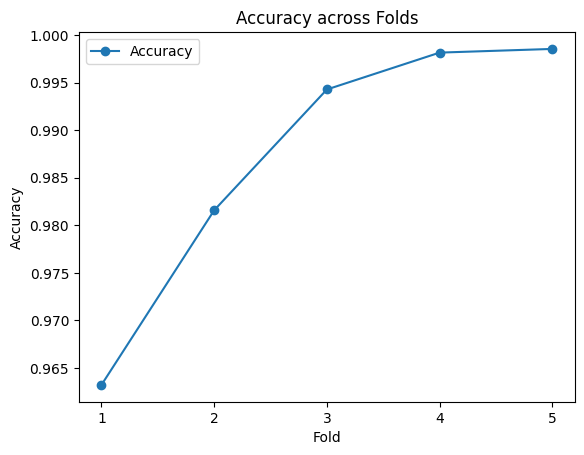

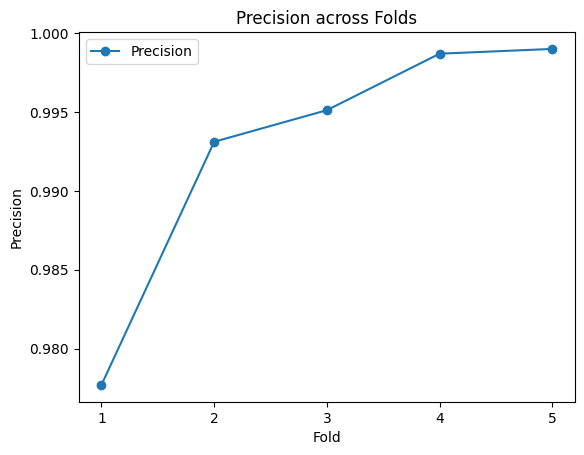

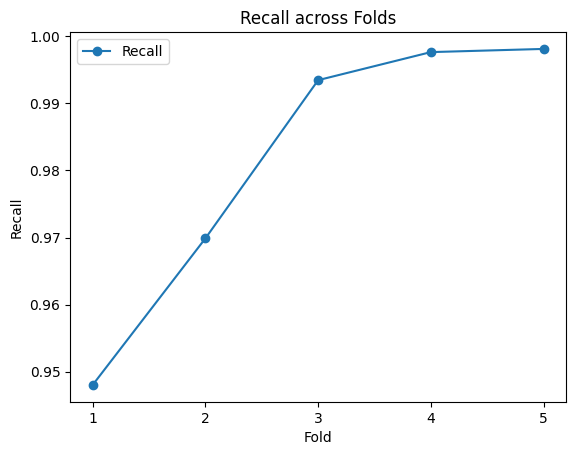

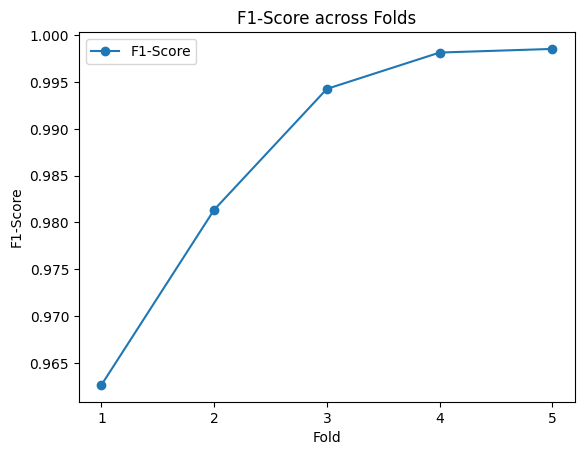

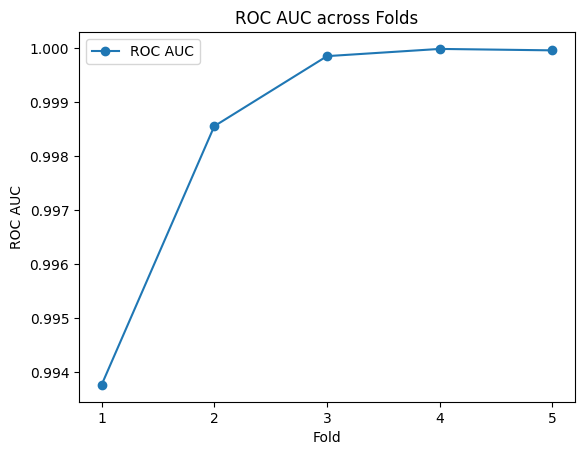

<Figure size 640x480 with 0 Axes>

In [21]:
training_accuracy_plt_filepath = "/content/drive/MyDrive/MDS_FYP/DistilBert_Intermediate/Training/training_accuracy_distilbert_v2.png"
training_precision_plt_filepath = "/content/drive/MyDrive/MDS_FYP/DistilBert_Intermediate/Training/training_precision_distilbert_v2.png"
training_recall_plt_filepath = "/content/drive/MyDrive/MDS_FYP/DistilBert_Intermediate/Training/training_recall_distilbert_v2.png"
training_f1scores_plt_filepath = "/content/drive/MyDrive/MDS_FYP/DistilBert_Intermediate/Training/training_f1scores_distilbert_v2.png"
training_rocauc_plt_filepath = "/content/drive/MyDrive/MDS_FYP/DistilBert_Intermediate/Training/training_rocauc_distilbert_v2.png"

# Plot validation accuracy across folds
plot_scores_across_folds(accuracy_scores_list, "Accuracy", output_file=training_accuracy_plt_filepath)
# Plot precision across folds
plot_scores_across_folds(precision_scores_list, "Precision", output_file=training_precision_plt_filepath)
# Plot recall across folds
plot_scores_across_folds(recall_scores_list, "Recall", output_file=training_recall_plt_filepath)
# Plot F1-score across folds
plot_scores_across_folds(f1_scores_list, "F1-Score", output_file=training_f1scores_plt_filepath)
# Plot ROC AUC across folds
plot_scores_across_folds(roc_auc_values, "ROC AUC", output_file=training_rocauc_plt_filepath)

# Cross-Validation Result

In [22]:
(avg_accuracy, avg_precision, avg_recall, avg_f1, avg_roc) = calc_avg_cv(accuracy_scores_list, precision_scores_list, recall_scores_list, f1_scores_list, roc_auc_values, N_FOLDS)

CSV_FILE_PATH = "/content/drive/MyDrive/MDS_FYP/DistilBert_Intermediate/CV/cv_metric_results_distilbert_v2.csv"
cv_eval = save_result_to_csv(avg_accuracy, avg_precision, avg_recall, avg_f1, avg_roc, CSV_FILE_PATH)

print(f"CV Accuracy Score: {avg_accuracy}")
print(f"CV Precision Score: {avg_precision}")
print(f"CV Recall Score: {avg_recall}")
print(f"CV F1 Score: {avg_f1}")
print(f"CV ROC AUC: {avg_roc}")

CV Accuracy Score: 0.9871593172744589
CV Precision Score: 0.9927292986055793
CV Recall Score: 0.9814201067243868
CV F1 Score: 0.9870012833966534
CV ROC AUC: 0.9984235695803964


# Output Model

In [23]:
output_model_file = "/content/drive/MyDrive/MDS_FYP/DistilBert_Intermediate/Model/distilbert_v2"
model.save_pretrained(output_model_file)